**DISCRIMINATORY INDEX COMPARISONS ACROSS STAKEHOLDER GROUPS**
<br>DI maps. 
<br>Files needed:
1. other_headmean_ss_ytna
2. moc_headmean_ss_ytna
3. other_headvar_ss_ytna
4. moc_headvar_ss_ytna
5. design

File structure:
<br> Run analyze_ensemble for each stakeholder and each stage of analysis, then save files needed for plots with appropriate filename, in a common folder

In [1]:
#Import packages:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import os
import sys
import pickle

**MODIFY SETTINGS HERE:**

In [2]:
#Identify file directory?
path = r'C:\Users\Chloe\Documents\Python\MODFLOW class\BASE\output\paper\likelihood'

#Identify stakeholders & stages to plot?
desired_stakeholders = ['ag','env','town']                      #choose from ag, env, or town
desired_stages = ['random','reseed','combine','afterdata']      #choose from random, reseed, combine, or afterdata

**IMPORT**

In [3]:
#Design info:

#design = 
#          [0: nrow        8: crop             15: K_horiz              22: str_rows
#           1: ncol        9: fNWc             16: Kzratio_low          23: str_cols]
#           2: delr       10: well1            17: Sy
#           3: delc       11: well2            18: R1
#           4: Lx         12: recharge_ratio   19: ET1
#           5: Ly         13: return_loc       20: ETratio_riparian
#           6: nlay       14: rNWc             21: Kratio_stream
#           7: ztop 


In [4]:
#Import model outputs from different stakeholders:

os.chdir(path)           #change to correct directory

#List all stakeholders, stages, and files:
stakeholders = ['ag','town','env']
stages = ['random','reseed','combine','afterdata']
files = ['other_headmean_ss_ytna','moc_headmean_ss_ytna','other_headvar_ss_ytna','moc_headvar_ss_ytna','design']

#Define a function to load model info from different stakeholders:
def load_info(stakeholder, stage):
    ensemble = stakeholder + '_' + stage
    return [np.load(ensemble + '_other_headmean_ss_ytna.npy'),np.load(ensemble + '_moc_headmean_ss_ytna.npy'),
            np.load(ensemble + '_other_headvar_ss_ytna.npy'),np.load(ensemble + '_moc_headvar_ss_ytna.npy')]

#Identify which files are actually available:
#initialize empty lists:
available_stakeholders = []
available_stages = []
available_ensembles = []
available_files = []
not_available = []
for stakeholder in stakeholders:
    for stage in stages:
        for file in files:
            ensemble = stakeholder + '_' + stage
            filename = ensemble + '_' + file + '.npy'
            pathtest = path + '\\' + filename           
            if os.path.exists(pathtest) == True:
                available_files.append(filename)
                if stakeholder not in available_stakeholders:
                    available_stakeholders.append(stakeholder)
                if stage not in available_stages:
                    available_stages.append(stage)
                if ensemble not in available_ensembles:
                    available_ensembles.append(ensemble)   
            else:
                not_available.append(filename)            
print('Available ensembles:','\n', available_ensembles, '\n')

#Create list of ensembles to plot from intersection of available and desired ensembles:
plot_stakeholders = list(set(desired_stakeholders) & set(available_stakeholders))
plot_stages = list(set(desired_stages) & set(available_stages))
plot_ensembles = []
for stakeholder in plot_stakeholders:
    for stage in plot_stages:
        ensemble = stakeholder + '_' + stage
        if ensemble in available_ensembles:
            plot_ensembles.append(ensemble)
print('Ensembles to plot:', '\n', plot_ensembles) 

#Import files to dictionaries:
#initialize empty dictionaries:
other_headmean_ss_ytna = {}
moc_headmean_ss_ytna = {}
other_headvar_ss_ytna = {}
moc_headvar_ss_ytna = {}
design = {}
for stakeholder in plot_stakeholders:      #loop
    for stage in plot_stages:
        [other_headmean_ss_ytna[stakeholder,stage], moc_headmean_ss_ytna[stakeholder,stage],
          other_headvar_ss_ytna[stakeholder,stage], moc_headvar_ss_ytna[stakeholder,stage]] = load_info(stakeholder,stage)  #call load function for current directory
        with open(stakeholder + '_' + stage + '_design', 'rb') as fp:    #use pickle for design because file includes multiple data types
            design[stakeholder,stage] = pickle.load(fp)

Available ensembles: 
 ['ag_random', 'ag_reseed', 'env_random', 'env_reseed'] 

Ensembles to plot: 
 ['ag_random', 'ag_reseed', 'env_random', 'env_reseed']


**PLOT**

C:\Users\Chloe\Anaconda3\envs\HWR582\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


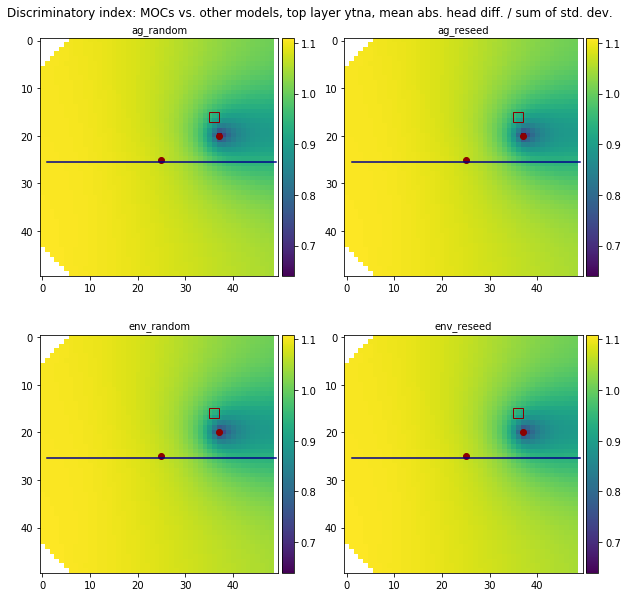

In [5]:
#Define lot function:
def make_color_plot(ax,design,data_ytna,minval):                                # use this to generate contour plots with streams, wells, return locations, infiltration areas and add x axis titles
    nrow = design[stakeholder,stage][0]           # pull model setup info from design file
    ncol = design[stakeholder,stage][1]
    str_rows = design[stakeholder,stage][22]
    str_cols = design[stakeholder,stage][23]
    well1 = design[stakeholder,stage][10]
    well2 = design[stakeholder,stage][11]
    return_loc = design[stakeholder,stage][13]
    rNWc = design[stakeholder,stage][14]
    extent = (0, ncol, 0, nrow)                   # sets plot boundaries (x0,x1,y0,y1)
    h=data_ytna
    h[h==0]=np.nan                                                                    # remove false zero values to improve color fill limits
    levels = np.arange(np.nanmin(h),np.nanmax(h),(np.nanmax(h)-np.nanmin(h))/100)     # creates an array of values used to determine which contour values to draw
    ax.invert_yaxis()                                                             # reverse y axis direction so that row 0 is at the top
    im = ax.imshow(h,cmap=cm.viridis)                                             # plot head as a colormap
    divider = make_axes_locatable(ax)                                             # set up colorbar location (need to import make_axes_locatable - see top cell)
    cax = divider.append_axes("right", size="5%", pad=0.05)                           # place colorbar axes on right side of each subplot
    plt.colorbar(mappable=im, cax = cax)                                              # draw colorbar
    ax.plot(str_cols, str_rows+.5, c='DarkBlue')                                  # plot stream location (col = x, row = y)
    ax.scatter(well1[2], well1[1], c='DarkRed')                               # plot town well location (col = x, row = y)
    ax.scatter(return_loc,25, c='DarkRed')                                    # plots town return location (col = x, row = y)
    townrect = patches.Rectangle((rNWc[2],rNWc[1]),2,2,linewidth=1,edgecolor='DarkRed',facecolor='none')
    ax.add_patch(townrect)
    ax.set_title(stakeholder + '_' + stage, size=10)
    
#DI calculations & plot setup:
title='Discriminatory index: MOCs vs. other models, top layer ytna, mean abs. head diff. / sum of std. dev.'
minval=0    # minimum allowable value ... only used for difference plot to identify measurable differences
nstk = len(plot_stakeholders)
nstg = len(plot_stages)
f1,ax1 = plt.subplots(nstg,nstk,figsize=(5*nstk,5*nstg))     # create & return figure & axes at position (row, col) of size 20x12 inches
plt.figtext(0.5, 0.9, title, ha='center', va='bottom', size=12)
plot_DI = {}
i = 0
for stakeholder in plot_stakeholders:
    j = 0
    for stage in plot_stages:
        plot_DI[stakeholder,stage]=np.abs(other_headmean_ss_ytna[stakeholder,stage]-moc_headmean_ss_ytna[stakeholder,stage])/(other_headvar_ss_ytna[stakeholder,stage]+moc_headvar_ss_ytna[stakeholder,stage])
        make_color_plot(ax1[i,j],design,plot_DI[stakeholder,stage],minval)
        j = j+1
    i = i+1

plt.show(f1)

In [6]:
#Calculate best location to collect data:

for stakeholder in available_stakeholders:
    for stage in available_stages:
        mean_dif=np.abs(other_headmean_ss_ytna[stakeholder,stage]-moc_headmean_ss_ytna[stakeholder,stage])
        var_sum=other_headvar_ss_ytna[stakeholder,stage]+moc_headvar_ss_ytna[stakeholder,stage]
        DI=mean_dif/var_sum
        DI[mean_dif<1e-5]=0
        DI[np.isnan(DI)]=0
        discindex_std=DI
        mask=np.floor(DI/np.nanmax(DI))
        cols=np.zeros((np.shape(DI)[0],np.shape(DI)[0]))
        rows=np.zeros((np.shape(DI)[0],np.shape(DI)[0]))
        for i in np.arange(np.shape(DI)[0]):
            cols[i,:]=np.arange(np.shape(DI)[0])
            rows[:,i]=np.arange(np.shape(DI)[0])
        maskedcols=mask*cols
        maskedrows=mask*rows
        maxcol=np.sum(maskedcols)
        maxrow=np.sum(maskedrows)
        print('Optimal data point for  time: ytna  stakeholder:',stakeholder,' stage:',stage,
              ' is located at row:',maxrow,' column:',maxcol,' in the top layer.')

Optimal data point for  time: ytna  stakeholder: ag  stage: random  is located at row: 43.0  column: 0.0  in the top layer.
Optimal data point for  time: ytna  stakeholder: ag  stage: reseed  is located at row: 43.0  column: 0.0  in the top layer.
Optimal data point for  time: ytna  stakeholder: env  stage: random  is located at row: 43.0  column: 0.0  in the top layer.
Optimal data point for  time: ytna  stakeholder: env  stage: reseed  is located at row: 43.0  column: 0.0  in the top layer.


C:\Users\Chloe\Anaconda3\envs\HWR582\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
